# Principal Component Analysis - Key Equities Driving S&P500

Equity and Fixed Income project

Authors: Adam Foster, Maciej Staniszewski

PCA is a dimensionality reduction method whereby multiple variables in a large dataset are transformed into a smaller set of variables, maintaining most of the information in the large dataset. Resulting variables are easier to explore and analyse and are less computationally expensive to process.

This exercise covers a practical demonstration of this approach, as well as its application in determining key single name equity drivers of the S&P500 index.

## Prerequisites

We recommend cloning the following Github repo to run this code locally and access the dataset used subsequently:
https://github.com/afoster28/efi-pca.git

Make sure to run the following command to install all required packages:
`pip install -r requirements.txt`

These include:
* `numpy` for basic mathematical operations
* `pandas` for dataset manipulations 
* `matplotlib` for data visualisation with plots
* `yfinance` for financial data

Dataset to be included in run folder (available on Github): `all_stocks_5yr.csv`

## PCA Details

### Step 1 - Standardisation

Standardisation involves the normalisation using mean and standard deviation and makes varying domains comparable. This prevents variables with larger domains dwarfing the impact of smaller domains, reducing bias.

$z = \frac{value - mean}{standard deviation}$

### Step 2 - Covariance Matrix

In searching for all possible relationships between the variables and their joint variance, a covariance matrix is created. For n variables, an $n\times n$ covariance matrix is formed.

We can observe a couple of interesting facts about the covariance matrix:
* Diagonal elements of the covariance matrix describe the variance of individual variables. This is because they contain information about the variability of the pair of values $(e1, e1)$ which is essentially the same as the variability of $e1$ for some variable $e1$.
* Another observation is that the matrix should be symmetrical about the diagonal. This means that elements $(e1, e2)$ vary in the same exact way as elements $(e2, e1)$. Note: that python libraries will raise a warning if the covariance matrix does not have that property.

### Step 3 - Eigendecomposition

Principal components are new variables that are constructed as linear combinations of the initial variables. These combinations are done in such a way that the principal components are uncorrelated and most of the information within the initial variables (and therefore the variance) is compressed into the first components.

Across all principal components, the same information is maintained. The advantage is that the minimum amount of information is lost when removing the least important components, hence a large proportion of the data can be represented in few components - they pick up the maximal amount of variance.

The first principal component is calculated to maximise the average of the squared distances from projected points to the origin. The second one is calculated the same way, provided it is uncorrelated with and therefore orthogonal to the first component. This can be continued for the number of dimensions of the data and each component has an associated eigenvector-eigenvalue pair. Eigenvectors described the direction of the axes where there is the most variance and eigenvalues show the amount of variance carried. Ranking eigenvectors by eigenvalues in descending order produces the principal components in order of significance. The eigenvalue relative to the sum of eigenvalues denotes the percentage of variance covered by the associated principal component.

#### Methodology

A point $x$ gets projected onto a unit vector $u$, a new point $x'$ is created whose magnitude is calculated by the inner product between $x$ and $u$: $x' = (x^{T}u)u$.

$(x^{T}u)^{2}$ can be thought of as the amount of information preserved and is maximal when $x$ is parallel to $u$ and minimal when $x$ is orthogonal to $u$. PCA is then an optimisation problem whereby it seeks to maximise information preserved subject to the unit vector usage:

$max \sum \limits _{i} (x _{i} ^{T} u)^{2}$ subject to $u^{T} u = 1$

which simplifies to

$max \text{ } u ^{T} C u$ subject to $u^{T} u = 1$ where $C = \frac{1}{n} \sum \limits _{i} x _{i} x _{i} ^{T}$ (covariance matrix)

This can be expressed as a Lagrangean and solved:

$L = u ^{T} C u - \lambda(u^{T} u - 1)$

$2 C u - 2 \lambda u = 0$

$C u = \lambda u$

Therefore, $u$ and $\lambda$ represent eigenvectors and eigenvalues, respectively. The best direction $u_{1}$ to pick is the eigenvector with the largest eigenvalue $\lambda_{1}$. $u_{2}$ can then be selected such that $u_{2} \perp u_{1}$ with $\lambda_{2}$ and so on.


### Step 4 - Feature Vector

At this stage, a process of elimination occurs based on principal component significance and the resulting components form the feature vector.


### Step 5 - Recast the Data along the PC Axes

Eigenvectors of the feature vector prinicpal components are used to reorient the data from the original axes to the ones represented by the principal components.

$Final Dataset = Feature Vector^{T} \times Standardised Original Dataset^{T}$

This data can be visualised in a more intuitive manner.


## Simple PCA Decomposition

In [109]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

We're now ready to use them to generate a simple dataset. We'll implement a data-generating function the results of which we'll be using as inputs to our PCA. 

The **aim of our exercise is to show, that results of principal components analysis align with theoretical, expected outcomes** for the dataset generated using the above function.

Our samples will be drawn from a Gaussian distribution in two dimensions, as follows:

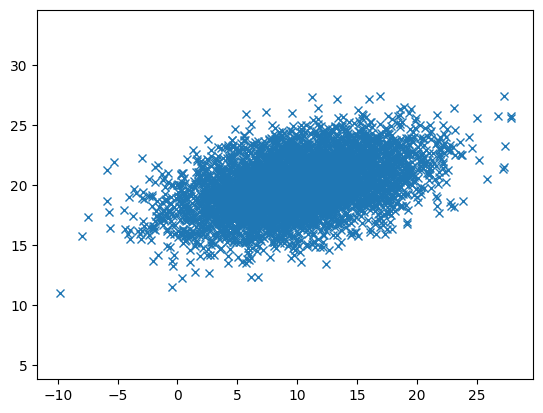

In [86]:
means = [10, 20]  # Means of marginal distributions
cov = [[25, 5], [5, 5]]  # diagonal covariance
x, y = np.random.multivariate_normal(means, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

PCA is based on eigenvalues and eigenvectors which can be computed using `numpy`:

In [87]:
values, vectors = np.linalg.eig(cov)
values[:5]

array([26.18033989,  3.81966011])

In [88]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(f"Total explained variance = {np.sum(explained_variances) * 100}%\nIndividual explained variances = {explained_variances}\n")

Total explained variance = 100.0%
Individual explained variances = [0.872677996249965, 0.12732200375003505]



We can see, that the variance is explained fully by the first two components. The first component explains over 87% of variance in the data. This is as expected, because the data was generated using two variables only. 

In [89]:
# Let's define a simple function that will format a vector for later printing
def print_vector(v):
    return( "({}, {})" ).format(round(v[ 0 ], 2), round(v[ 1 ], 2))

In [90]:
# Eigenvectors obtained through the decomposition:
for i, v in enumerate(zip( vectors, values )):
    # Using the small helper function defined above
    print( f"Eigenvector {i}:\t{print_vector(v[ 0 ])} with value {round(v[ 1 ], 2)}" )

Eigenvector 0:	(0.97, -0.23) with value 26.18
Eigenvector 1:	(0.23, 0.97) with value 3.82


These eigenvectors are two-dimensional. We can easily plot them over the original data set as follows:

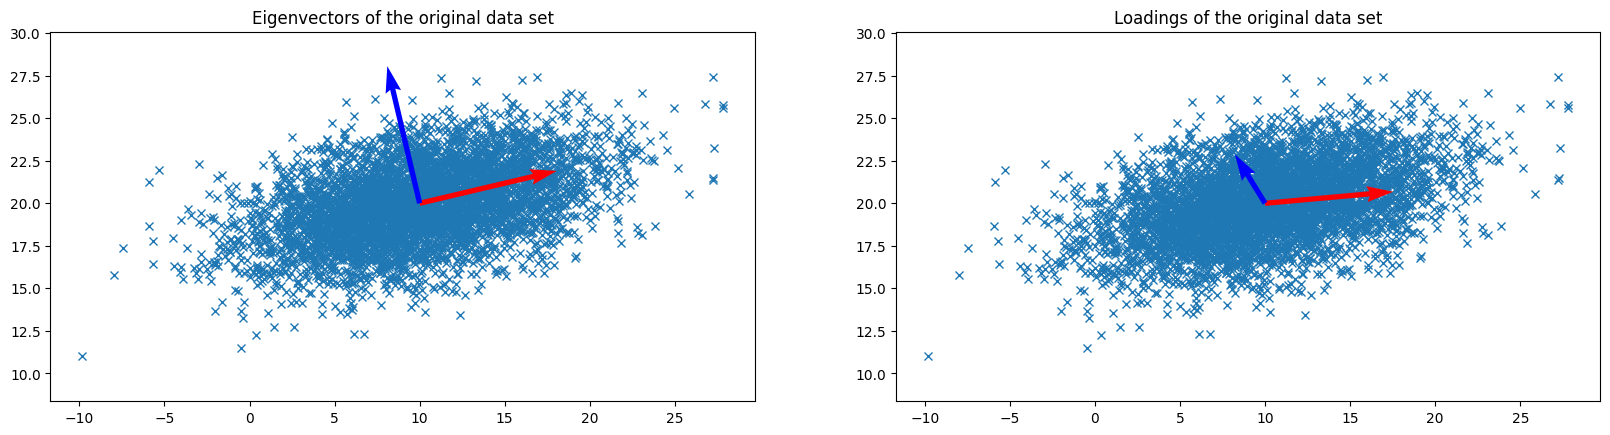

In [91]:
origin = [[means[0], means[0]], [means[1], means[1]]]

fig, ax = plt.subplots(nrows=1, ncols=2)

# Plotting actual eigenvectors on the left
ax[ 0 ].plot(x, y, 'x', zorder=1)
ax[ 0 ].axis('equal')
ax[ 0 ].set_title('Eigenvectors of the original data set')
ax[ 0 ].quiver(*origin, vectors[ 0 ], vectors[ 1 ], 
            color=['r','b'], scale=5, zorder=2)

# Plotting scaled eigenvectors - "loadings" on the right. For details see references.
ax[ 1 ].plot(x, y, 'x', zorder=1)
ax[ 1 ].axis('equal')
# Loadings are eigenvectors which are scaled by the square root of the explained variance 
ax[ 1 ].set_title('Loadings of the original data set')
ax[ 1 ].quiver(*origin, 
               np.dot( vectors[ 0 ], np.sqrt( explained_variances[ 0 ] ) ), 
               np.dot( vectors[ 1 ], np.sqrt( explained_variances[ 1 ] ) ),               
               color=['r','b'], scale=5, zorder=2)

fig.set_figwidth(20)
plt.show()

The first (red) eigenvector is in fact explaining most of the variance as computed above. The horizontal dispersion is dominant and receives more weight through the eigenvalue. The vertical dispersion is smaller in comparison and less important overall. Note, how the directions of eigenvectors appropriately reflect the tilt introduced by the correlation structure.

We will now download actual financial data observed in the market. That way we will observe the differences in PCA behavior between empirical data and data from the data generating process.

## Real-world Data

A good example of features varying together is a financial equity index. One of the most popular ones is the ***S&P500*** (*"Standard and Poor's 500"*). It measures cumulative performance of 500 selected largest US equity stocks that trade on the New York Stock Exchange. We will use PCA to explain the variability of this complex index by fewer stocks, that belong to this investment bucket. 

### Goal

Our goal is to show the individual stocks included in the S&P500 index that drive the overall variance the most.

### Dataset

We downloaded 5-year historical data containing information about stock prices of all S&P500 underliers as of February 2018 from Kaggle (link is in the References). We will use this dataset for our empirical study.

### Loading and Preparing the Dataset

Let's use `pandas` to load the dataset:

In [92]:
stocks = pd.read_csv('all_stocks_5yr.csv')
stocks.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [93]:
stocks.tail()

,date,open,high,low,close,volume,Name
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.69,73.86,4534912,ZTS


We will be interested in the ***close*** column as it is a feature commonly used in the industry that offers accurate precision to reflect the stock price of a stock.

In [94]:
stocks = stocks[['date', 'close', 'Name']]
unique_names = pd.unique(stocks.loc[:,'Name'])

Let's now load the actual S&P500 prices for the same period:

In [95]:
import yfinance as yf
snp = yf.download("%5EGSPC", start="2013-02-08", end="2018-02-07")
snp.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-08,1509.390015,1518.310059,1509.390015,1517.930054,1517.930054,2986150000
2013-02-11,1517.930054,1518.310059,1513.609985,1517.010010,1517.010010,2684100000
2013-02-12,1517.010010,1522.290039,1515.609985,1519.430054,1519.430054,3414370000
2013-02-13,1519.430054,1524.689941,1515.930054,1520.329956,1520.329956,3385880000
2013-02-14,1520.329956,1523.140015,1514.020020,1521.380005,1521.380005,3759740000


In [96]:
snp = snp[['Close']]
snp.tail()

,Close
Date,
2018-01-31,2823.810059
2018-02-01,2821.979980
2018-02-02,2762.129883
2018-02-05,2648.939941
2018-02-06,2695.139893


S&P data is not loaded for days between 2018-01-30 and 2018-02-07. We will trim individual stock prices scope to align with that limitation:

In [97]:
stocks = stocks[stocks['date'] <= '2018-02-06']
stocks.tail()

,date,close,Name
619034,2018-01-31,76.73,ZTS
619035,2018-02-01,77.82,ZTS
619036,2018-02-02,76.78,ZTS
619037,2018-02-05,73.83,ZTS
619038,2018-02-06,73.27,ZTS


The first step, as discussed before, is to obtain the covariance matrix. We cannot simply call `.cov()` on `stocks`, as all `close` values are in a single column spanning over all stocks that we have in the index. We need to re-pivot the data, so that every stock gets it's own `close` column with stock prices for all dates.

In [98]:
pivoted_stocks = pd.DataFrame(np.unique(stocks['date']), columns=['date'])
pivoted_stocks.set_index('date')
pivoted_stocks.head()

,date
0,2013-02-08
1,2013-02-11
2,2013-02-12
3,2013-02-13
4,2013-02-14


`pivoted_stocks` DataFrame defined above contains all possible unique dates. We will now try to extend this table with new columns for every stock name that we have. The `close` data will be joined to that table based on the date that we already put inside `pivoted_stocks`. 

If the code below is taking long (~60 seconds) to compute - **this can be expected** - the dataset we're trying to process is fairly large.

In [99]:
# Discussed in a comment inside the loop below
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for name in unique_names:                                                   # For all unique names that we have in the dataset
    prices_for_this_name = stocks[stocks['Name'] == name]                   # Find all prices for a given stock name 
    joined = pivoted_stocks.join(prices_for_this_name.set_index('date'),    # Join those individual stock prices with the list of unique dates
                                 on='date')
    pivoted_stocks[name] = joined['close'].values                           # Add a new column to the dataset with a name representing a stock
    
    #NOTE: Even though we get 'performance warnings', the above line is much much faster than the recommented pd.concat() below:
    #pivoted_stocks = pd.concat([pivoted_stocks, pd.Series(joined['close'].values, name=name)])

Finally, we can set `date` column as the index in the table and see how well it was populated:

In [100]:
pivoted_stocks.set_index('date', inplace=True)
pivoted_stocks.tail()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,54.32,167.43,116.99,112.22,99.67,62.16,160.70,199.76,91.88,42.95,...,73.02,36.84,87.30,60.81,34.13,72.26,84.59,127.12,54.03,76.73
2018-02-01,53.88,167.78,117.29,116.34,99.29,62.18,160.46,199.38,91.65,42.46,...,72.49,36.79,89.07,60.73,32.75,74.84,83.98,128.19,54.98,77.82
2018-02-02,52.10,160.50,113.93,115.17,96.02,61.69,156.90,195.64,89.11,41.43,...,70.64,38.25,84.53,60.06,31.63,75.66,82.63,125.79,54.15,76.78
2018-02-05,49.76,156.49,109.86,109.51,91.90,58.73,151.83,190.27,85.40,40.60,...,66.97,37.68,79.72,58.54,31.38,72.66,79.80,123.18,51.65,73.83
2018-02-06,51.18,163.03,112.20,111.20,91.54,58.86,154.69,194.47,88.54,42.00,...,68.99,37.34,78.35,58.46,30.85,71.33,80.58,122.30,52.52,73.27


Now we want to normalize the data; we will calculate daily returns for both equity prices and the S&P500 index:

In [101]:
pivoted_stocks = pivoted_stocks.pct_change().fillna(0)
pivoted_stocks.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-02-11,-0.019661,0.010422,-0.006464,-0.011034,-0.002772,-0.004359,-0.003274,-0.012270,0.008315,0.001985,...,-0.001333,0.002479,-0.003724,-0.000700,0.003769,0.013658,-0.011485,-0.002637,0.002900,0.006354
2013-02-12,-0.013140,-0.025067,0.002679,-0.011994,0.004277,0.001168,0.004106,0.006470,0.004123,0.017503,...,0.003203,0.003532,0.002039,0.000700,-0.003755,0.017844,0.003098,-0.002776,0.011565,0.014432
2013-02-13,0.027330,-0.001903,0.004707,-0.004235,-0.006814,0.004665,0.002590,-0.002057,-0.000216,0.011360,...,0.005854,0.000352,0.002374,0.004899,0.005025,0.011091,-0.005251,0.007423,0.010208,-0.005631
2013-02-14,-0.045703,-0.000899,-0.001646,0.036859,0.002787,0.006965,-0.005846,-0.005153,0.006053,0.007702,...,0.016931,-0.007037,-0.001692,-0.003946,0.003750,0.007431,-0.008073,0.004474,-0.004446,-0.008346


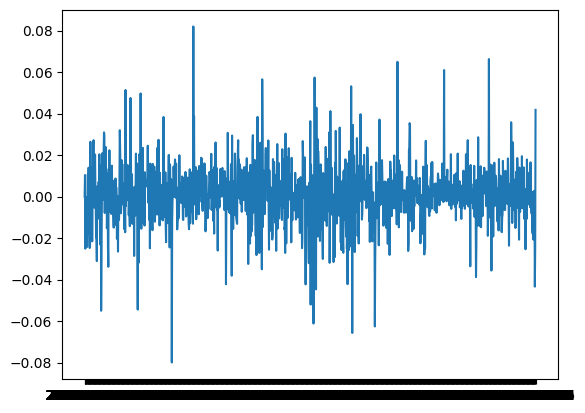

In [195]:
# Clear plot area
plt.cla()
plt.clf()

plt.plot(pivoted_stocks['AAPL'])

Now for the index normalization:

In [102]:
snp = snp.pct_change().fillna(0)
snp.head()

,Close
Date,
2013-02-08,0.000000
2013-02-11,-0.000606
2013-02-12,0.001595
2013-02-13,0.000592
2013-02-14,0.000691


In [ ]:
# Clear plot area
plt.cla()
plt.clf()

plt.plot(snp)

Everything is in appropriate format. We're ready to compute the covariance matrix for this data. We note that it is symmetric as expected, and that the resulting eigenvectors will be orthogonal. As a reminder: the intention is to find the main equities driving principal components (hence only equities in the covariance matrix) which will then be compared to the overall S&P500 results.

In [104]:
stocks_cov = pivoted_stocks.cov()
stocks_cov.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
AAL,0.000504,0.000069,0.000082,0.000085,0.000072,0.000080,0.000076,0.000104,0.000105,0.000075,...,0.000088,0.000079,0.000043,0.000073,0.000105,0.000087,0.000092,0.000074,0.000119,0.000079
AAPL,0.000069,0.000213,0.000035,0.000045,0.000029,0.000048,0.000051,0.000065,0.000087,0.000040,...,0.000059,0.000034,0.000041,0.000044,0.000064,0.000052,0.000060,0.000053,0.000062,0.000049
AAP,0.000082,0.000035,0.000359,0.000068,0.000044,0.000065,0.000047,0.000050,0.000056,0.000063,...,0.000053,0.000042,0.000043,0.000046,0.000069,0.000061,0.000065,0.000054,0.000085,0.000044
ABBV,0.000085,0.000045,0.000068,0.000284,0.000079,0.000090,0.000055,0.000076,0.000073,0.000067,...,0.000073,0.000042,0.000055,0.000061,0.000074,0.000067,0.000054,0.000082,0.000074,0.000089
ABC,0.000072,0.000029,0.000044,0.000079,0.000194,0.000062,0.000044,0.000044,0.000041,0.000036,...,0.000037,0.000044,0.000032,0.000050,0.000049,0.000038,0.000038,0.000046,0.000056,0.000055


### Decomposition of the S&P500 Index - Eigendecomposition

Now for the best part - obtaining the eigenvectors from the covariance matrix above:

In [120]:
eigenvalues, eigenvectors = np.linalg.eig(stocks_cov)

In [196]:
# Eigenvectors obtained through the decomposition:
for i, v in enumerate(zip( eigenvectors, eigenvalues )):
    # Using the small helper function defined above
    print( f"Dimensionality of vector {i}:\t{len( v[ 0 ] )} with value {v[ 1 ]}" )

Dimensionality of vector 0:	505 with value 0.03376173694935521
Dimensionality of vector 1:	505 with value 0.0061761006559634506
Dimensionality of vector 2:	505 with value 0.0040611287292239085
Dimensionality of vector 3:	505 with value 0.0025436303195844746
Dimensionality of vector 4:	505 with value 0.002096464901497465
Dimensionality of vector 5:	505 with value 0.00176739713167066
Dimensionality of vector 6:	505 with value 0.001519248229148273
Dimensionality of vector 7:	505 with value 0.0012966572006962124
Dimensionality of vector 8:	505 with value 0.0012581660613419543
Dimensionality of vector 9:	505 with value 0.0011673882894033003
Dimensionality of vector 10:	505 with value 0.0011513412481820337
Dimensionality of vector 11:	505 with value 0.0010856190395641563
Dimensionality of vector 12:	505 with value 0.0009960239191022984
Dimensionality of vector 13:	505 with value 0.000983676083128175
Dimensionality of vector 14:	505 with value 0.000940458688838085
Dimensionality of vector 15:

In [ ]:
eigenvectors[ 0 ]

array([-6.07072279e-02,  5.55305114e-02, -6.55871376e-02,  4.70878629e-03,
        2.62434287e-02,  7.92773837e-02,  6.82722788e-02,  1.58245110e-01,
       -2.44580293e-01,  4.74152479e-02,  4.66553310e-02, -1.77453106e-01,
        1.46041694e-01,  1.05393971e-02, -1.30534630e-01, -1.07989929e-01,
        7.01651531e-02,  2.22378548e-02, -3.19009429e-03,  1.04863787e-01,
        4.46563897e-02,  1.24465383e-02,  3.16860575e-02,  3.25405076e-02,
        1.79653337e-02,  4.42303400e-02,  3.69798590e-02, -3.72168400e-02,
        1.72988466e-02, -3.25720861e-02,  6.39777227e-02, -2.42724183e-02,
        1.50596156e-02, -1.99528460e-03, -1.06001928e-02, -3.24210237e-02,
        5.62660237e-03,  5.19697914e-03, -9.64850336e-03,  1.80889229e-02,
        1.27186054e-02, -2.84929759e-02, -5.15552723e-02, -4.07684311e-02,
       -8.85412813e-02,  8.01000069e-02,  3.97734457e-02,  5.59278623e-02,
       -7.53187364e-02, -6.50246919e-02, -3.89759324e-02, -2.76724187e-02,
       -2.09046697e-02, -

There are as many $(eigenvector, eigenvalue)$ pairs calculated as there are dimensions in the model. Each eigenvector has total elements equal to the number of dimensions. Eigenvectors are sorted in order of decreasing absolute value of the corresponding eigenvalue.

Let's investigate the contribution of each eigenvector to overall variance captured:

In [127]:
explained_variances = []
for i in range(len(eigenvalues)):
    explained_variances.append(100 * eigenvalues[i] / np.sum(eigenvalues))
 
print(f"Total explained variance = {np.sum(explained_variances)}%\nIndividual explained variances = {explained_variances[0:7]}\n")

Total explained variance = 100.0%
Individual explained variances = [26.64816168411795, 4.874800402135239, 3.2054516377138595, 2.007689122232979, 1.6547411569489707, 1.3950077448756835, 1.1991436491962317]



## Decomposition Results
We see, that the first eigenvector accounts for over 26% of overall variance of S&P500 returns. It is by far the most important component, explaining almost 7x the variance, which is captured by the next best principal component.  

Financially speaking, we note that the majority of the overall variance cannot be explained by a linear combination of equity stock returns. 26% is, however, very impressive considering the high dimension size and the complexity of the index. This principal component transformation capability is the first interesting finding of our model. 

The first principal component could potentially be used for future index return predictions whereby instead of using all 500 underlying equities only this one principal component can be used to reflect index returns with 26% accuracy based on historical calculation. S&P500 data availability makes this rather unnecessary. 

Note, in this excercise we want to show another interesting application of PCA: ***to show which are the key equities driving S&P500 returns***.

### Feature Selection Process
Let's first consider a simplified situation in which there are only two variables which are defining a two-dimensional vector:

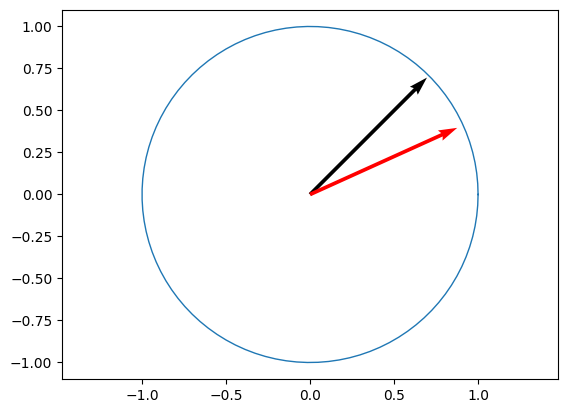

In [224]:
t = np.linspace(0,np.pi*2,100)
plt.axis('equal')
plt.plot(np.cos(t), np.sin(t), linewidth=1, zorder=1)
plt.quiver(0, 0, np.sqrt(2), np.sqrt(2), scale=6, zorder=2)
plt.quiver(0, 0, 0.89, 0.403, scale=3, zorder=2, color='red')

The key idea is to see that the x-coordinate of the red vector is greater than the y-coordinate. The variable on the x-axis is therefore better placed to capture more of the model variance.

#### More Dimensions

The same idea applies to eigenvectors of higher dimensions. The key algorithm that we devised is as follows:
 - Obtain the covariance matrix from underlying data 
 - Extract the top eigenvector
 - Select the several top coordinates by magnitude, i.e. contribution to eigenvector construction
 - Map these coordinates back to the underlying equities
 - Retrieve these equities and plot them agains the S&P500 

In [225]:
# 1. Take the top eigenvector
# 2. Apply `np.abs` to get the magnitudes of coordinates
# 3. Sort coordinates by magnitudes 
# 4. Retrieve the indices of top 5 equities driving the eigenvector
first_component_drivers = np.abs( eigenvectors[ 0 ] ).argsort()[:5]
first_component_drivers

array([390, 501, 347, 342, 500])

We've obtained our indices which we will now map back to the equities:

In [226]:
drivers = pivoted_stocks.iloc[:,first_component_drivers]
drivers

,RCL,YUM,NWL,NSC,XYL
date,,,,,
2013-02-08,0.000000,0.000000,0.000000,0.000000,0.000000
2013-02-11,0.002768,-0.011485,-0.008285,0.022754,0.013658
2013-02-12,0.005796,0.003098,0.010443,0.015162,0.017844
2013-02-13,-0.022777,-0.005251,-0.006614,0.003350,0.011091
2013-02-14,0.001404,-0.008073,0.010404,0.001252,0.007431
...,...,...,...,...,...
2018-01-31,0.002026,0.000000,0.027594,0.005531,-0.011085
2018-02-01,-0.001797,-0.007211,0.036309,-0.015973,0.035704
2018-02-02,-0.027380,-0.016075,0.021168,-0.023170,0.010957


The table above is missing S&P data - let's add it:

In [230]:
snp['date'] = snp.index.strftime('%Y-%m-%d') # Convert index to proper format
joined = drivers.merge(snp, left_on='date', right_on='date') 
drivers['SNP'] = joined['Close'].values  # Let's ignore that performance warning as the dataset is small.
drivers  

/tmp/ipykernel_178654/2770823921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drivers['SNP'] = joined['Close'].values  # Let's ignore that performance warning as the dataset is small.


,RCL,YUM,NWL,NSC,XYL,SNP
date,,,,,,
2013-02-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-02-11,0.002768,-0.011485,-0.008285,0.022754,0.013658,-0.000606
2013-02-12,0.005796,0.003098,0.010443,0.015162,0.017844,0.001595
2013-02-13,-0.022777,-0.005251,-0.006614,0.003350,0.011091,0.000592
2013-02-14,0.001404,-0.008073,0.010404,0.001252,0.007431,0.000691
...,...,...,...,...,...,...
2018-01-31,0.002026,0.000000,0.027594,0.005531,-0.011085,0.000489
2018-02-01,-0.001797,-0.007211,0.036309,-0.015973,0.035704,-0.000648
2018-02-02,-0.027380,-0.016075,0.021168,-0.023170,0.010957,-0.021209


Above tickers correspond to:
* **RCL** - Royal Caribbean Cruises Ltd. - world's second-largest cruise holding company
* **YUM** - Yum! Brands, Inc. - fast food company including KFC, Pizza Hut and Taco Bell brands
* **NWL** - Newell Brands - manufacturer, marketer and distributor of consumer and commercial products
* **NSC** - Norfolk Southern Railway - freight railroad operating in the Eastern United States
* **XYL** - Xylem Inc. - large American water technology provider, in public utility, residential, commercial, agricultural and industrial settings

We're ready to inspect our results visually:

<Axes: title={'center': 'Key component equity returns and S&P500 returns (2013)'}, xlabel='date'>

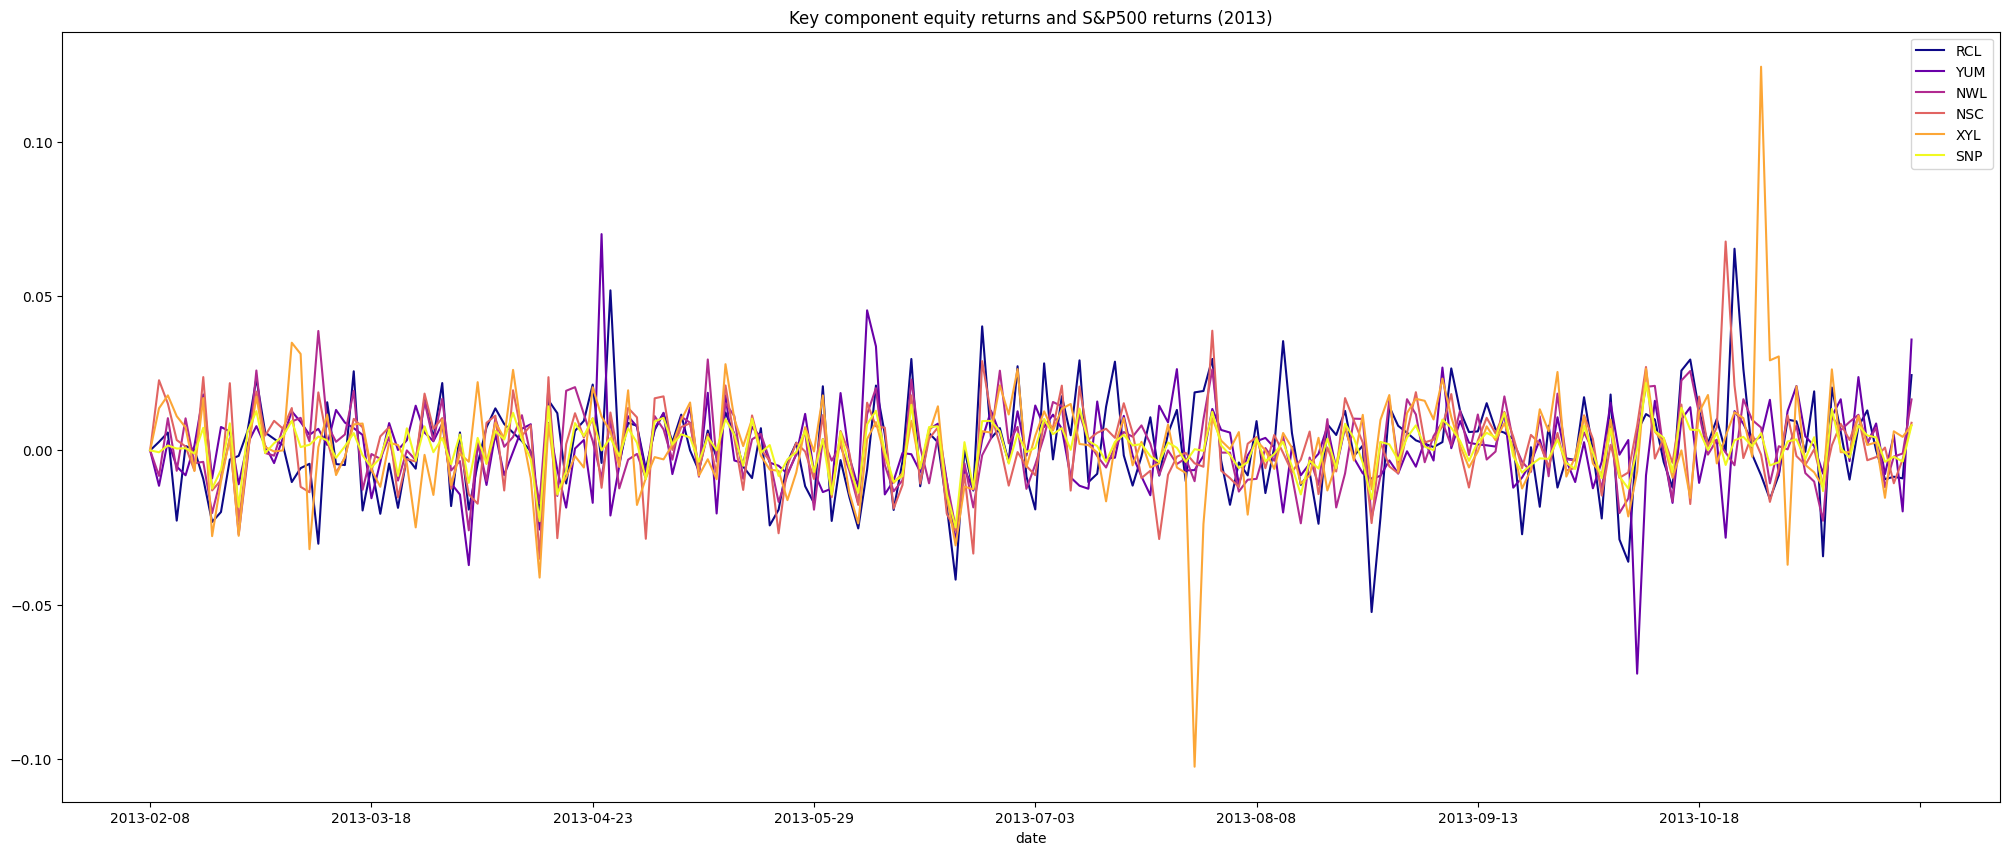

In [242]:
drivers.iloc[0:200].plot(figsize=(25, 10), colormap='plasma', title='Key component equity returns and S&P500 returns (2013)')

<Axes: title={'center': 'Key component equity returns and S&P500 returns (2016)'}, xlabel='date'>

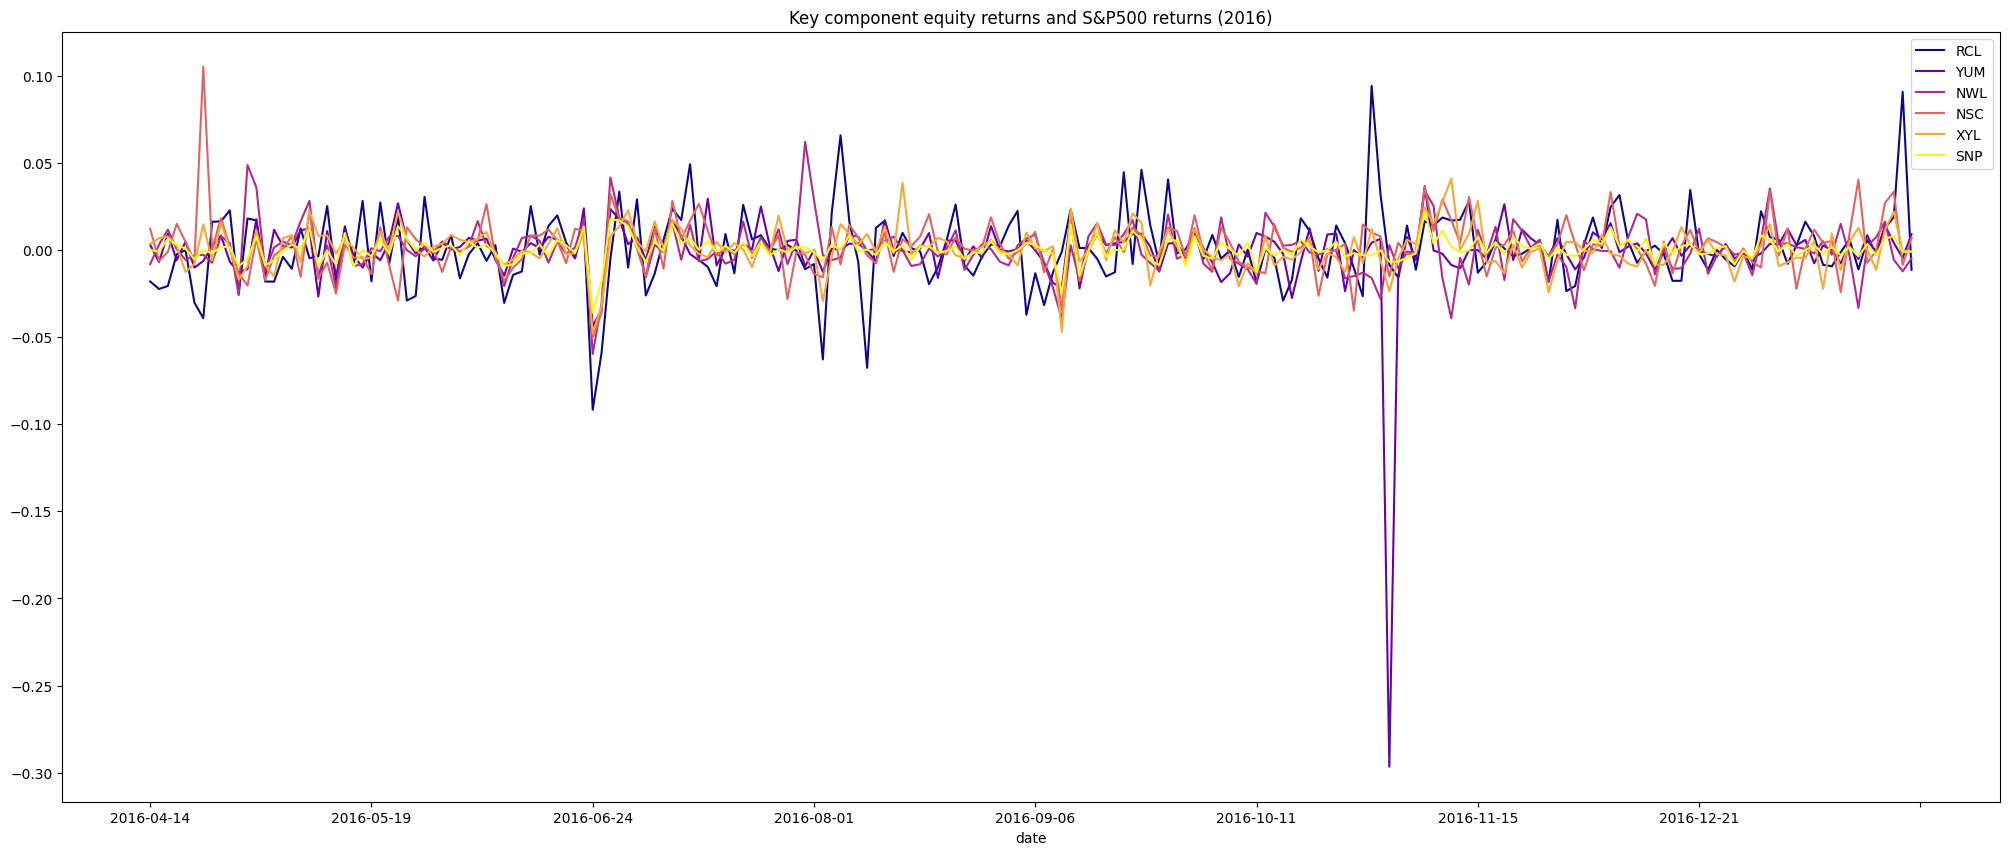

In [243]:
drivers.iloc[800:1000].plot(figsize=(25, 10), colormap='plasma', title='Key component equity returns and S&P500 returns (2016)')

## Findings

* We were able to represent individual returns of equities inside the S&P500 index principal components
* We found that the most important component explains over 26% of the index's variance
* We applied additional methodology to extract top 5 equities driving this main component
* This analysis provides better understanding of a simpler representation of the returns of the S&P500 
* Successful analysis can be performed on the subset of equities found reducing analytical and computational resources

## References
* https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
* https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another
* https://www.kaggle.com/datasets/camnugent/sandp500
* https://builtin.com/data-science/step-step-explanation-principal-component-analysis